# Laboratory Notebook

## Preliminary note

In order to correctly view the Javascript content and use the internal hyperlinks, please check the notebook at the following address: [https://nbviewer.jupyter.org/github/open-sci/2020-2021/blob/master/docs/Grasshoppers/arcangelo_notebook.ipynb](https://nbviewer.jupyter.org/github/open-sci/2020-2021/blob/master/docs/Grasshoppers/arcangelo_notebook.ipynb).

## Table of contents

1. [24/03/2021 Preliminary research](#preliminary)
2. [28/03/2021 Writing the abstract](#abstract)
3. [29/03/2021 Full reading of the DOI Handbook](#handbook)
4. [03/04/2021 Data Management Plan Version 1.0](#dmp1)
5. [09/04/2021 Literature review](#literature)
6. [11/04/2021 Computational workflow Version 1.0](#workflow1)
7. [17/04/2021 Open peer review](#peerReview)
8. [17/04/2021 First version of the regular expression to clean DOI's wrong prefixes](#regex1)
9. [20/04/2021 Reflections on Open Source Licenses](#license)
10. [20/04/2021 Code to handle HTTP requests](#requests)
11. [22/04/2021 Improvements to the regex to clean up prefix errors and code modularization](#modularization)
12. [23/04/2021 Final algorithm design](#final_algorithm)
13. [27/04/2021-29/04/2021 Visualizations](#viz)
14. [30/04/2021 Public Data File from Crossref](#crossref_dump)
15. [01/05/2021-02/05/2021-03/05/2021 Writing and editing the article](#article)
16. [08/05/2021 Results cache](#results_cache)
17. [12/05/2021 Unittest](#unittest)
18. [16/05/2021 Manual verification of results](#random_100)
19. [18/05/2021 Comparison with the results obtained by the Xu et al. procedure](#xu_comparison)

## 24/03/2021 Preliminary research <a name="preliminary"></a>

<p>Today I started working on the problem of wrong DOI names reported by Crossref. In particular, the research question on which the entire work focuses is which are the classes of errors that characterize the invalid DOI names and which classes can be addressed through automatic processes in order to obtain the correct DOI names.<p/>
<p>Having never used the DOI API, I explored the subject by reading its documentation<sup><a href="#preliminary_ref_01">[1]</a></sup>. In particular, in chapter <em>3.8.3 Proxy Server REST API</em> I discovered that by performing a GET to https://doi.org/api/handles/&lt;doi&gt; it is possible to obtain useful information in response. Among these, the status code is particularly interesting, which can take on four values:
<ul>
    <li>1: Success. (HTTP 200 OK)</li>
    <li>2: Error. Something unexpected went wrong during handle resolution. (HTTP 500 Internal Server Error)</li>
    <li>100: Handle Not Found. (HTTP 404 Not Found)</li>
    <li>200: Values Not Found. The handle exists but has no values (or no values according to the types and indices specified). (HTTP 200 OK)</li>
</ul>
This is extremely useful for identifying those initially invalid DOI names that have become valid in the meantime.</p>
   
### Reference
<ol>
    <li id="preliminary_ref_01">International DOI Foundation. (2019). DOI® Handbook. <a href="https://doi.org/10.1000/182" target="_blank">https://doi.org/10.1000/182</a>.</li>
</ol>

## 28/03/2021 Writing the abstract <a name="abstract"></a>

<p>Together with my colleagues Cristian Santini (orcid: 0000-0001-7363-6737), Ricarda Boente (orcid: 0000-0002-2133-8735) and Deniz Tural (orcid: 0000-0002-6391-4198) I wrote the first version of the abstract.</p>
<p>Starting from the initial hypothesis that there are two classes of errors, namely factual errors and DOI names that are not yet valid at the time of processing, we tried to further break down the first class into various subclasses: exploring the input dataset, we hypothesized that a DOI name may be factually wrong because it contains forbidden characters, because it contains excess strings at the beginning or at the end or due to a human error in the transcription.</p>
<p>Moreover, I have elaborated a first hypotheses on how to deal with both errors' classes. As for the first class, I speculated that it would be possible to obtain the correct cited DOI names starting from the valid citing DOI names, using the REST API for COCI: to obtain through the COCI references operation all the cited articles and, using word embeddings algorithm, to identify the most similar DOI name to the wrong one. However, my colleagues have rightly pointed out that wrong DOI names are not accepted by COCI and that COCI is built from Crossref, so it would not be possible to get the correct DOI names from COCI. Another hypothesis proposed by Cristian was to exploit other metadata provided by Crossref relating to that particular wrong DOI name to check if there are other DOI names connected to it, which perhaps refer to the correct one. Finally, it was decided to remain as vague as possible in the abstract and to summarize the various hypotheses formulated in the expression "rule-based methods" with the idea of defining this point after further research.<p/>
<p>Instead, there has been much more consensus on the strategy for dealing with the second class of errors, namely those due to DOI names that are not yet valid, that is, use the DOI API by interpreting the response status code.</p>

## 29/03/2021 Full reading of the DOI Handbook <a name="handbook"></a>

<p>Writing the abstract raised some questions about the specifics of a DOI name. Therefore, I decided to read the entire documentation with the aim of answering three questions:
<ol>
    <li>Do DOI names use a limited character set?</li>
    <li>Do DOI names have semantics?</li>
    <li>In which ways can I query the DOI System Proxy Server?</li>
</ol>
<p>Chapter <em>2.5.1 Encoding principle</em> answers the first question:</p>
<blockquote>"DOI names may incorporate any printable characters from the Universal Character Set (UCS-2), of ISO / IEC 10646, which is the character set defined by Unicode. The character set encompasses most characters used in every major language written today. However, because of specific uses made of certain characters by some Internet technologies (the use of pointed brackets in xml for example), there may some effective restrictions in day-to-day use."</blockquote>
<p>Chapter <em>2.2.1 General characteristics</em> answers the second question:</p>
<blockquote>The DOI name is an opaque string for the purposes of the DOI system. No definitive information may be inferred from the specific character string of a DOI name. In particular, the inclusion in a DOI name of any registrant code allocated to a specific registrant does not provide evidence of the ownership of rights or current management responsibility of any intellectual property in the referent. Such information may be asserted in the associated metadata.</blockquote>
<p>As for the third question, chapter <em>3.8.4.2 Parameter Passing</em> explores a series of queries that can be performed to specify the desired output. Therefore, I hypothesized that among the wrong DOI names there could be some that, during the extraction phase, had not been deprived of the query portion. The hypothesis was confirmed. The code used to perform this check is shown below.</p>

In [1]:
import csv, re, urllib.request

url = 'https://zenodo.org/record/4625300/files/invalid_dois.csv'
response = urllib.request.urlopen(url)
lines = [l.decode('utf-8') for l in response.readlines()]
reader = csv.reader(lines)
rows_number = 0
proxy_server_occurrences = list()
proxy_server_queries = set()
for row in reader:
    rows_number += 1
    query = re.search("\?.+?=", row[1])
    if query is not None:
        query = query.group(0)
        proxy_server_occurrences.append(query)
        proxy_server_queries.add(query)
print(f"The wrong DOI names that contain queries are {len(proxy_server_occurrences)} out of {rows_number}")
print(f"The number of queries found is equal to {len(proxy_server_queries)}. They are:")
print(proxy_server_queries)

The wrong DOI names that contain queries are 228 out of 1223297
The number of queries found is equal to 39. They are:
{'?locale=', '?title=', '?accountid=', '?articleid=', '?term=', '?goto=', '?id=', '?slug=', '?src=', '?sequence=', '?nosfx=', '?select-row=', '?download=', '?code=', '?refreqid=', '?abstract_id=', '?rss=', '?ver=', '?crawler=', '?doi=', '?origin=', '?print=', '?error=', '?artid=', '?scroll=', '?site=', '?prd=', '?arnumber=', '?rskey=', '?page=', '?v=', '?no-access=', '?sid=', '?doid=', '?genre=', '?report=', '?uid=', '?ref=', '?seq='}


## 03/04/2021 Data Management Plan Version 1.0 <a name="dmp1"></a>

<p>Together with my colleagues I compiled version 1.0 of the Data Management Plan, using the ARGOS platform by OpenAIRE and EUDAT. Two datasets were considered: one for the output and the other for the code. Particular care was taken in filling in as many fields as possible, but some doubts arose about which metadata to use in order to comply with the FAIR principles<sup><a href="#dmp1_ref_01">[1]</a><a href="#dmp1_ref_02">[2]</a><a href="#dmp1_ref_03">[3]</a></sup>, an aspect that will be further explored later.</p>

### Reference
<ol>
    <li id="dmp1_ref_01">Wilkinson, M. D., Dumontier, M., Aalbersberg, I. J., Appleton, G., Axton, M., Baak, A., Blomberg, N., Boiten, J.-W., da Silva Santos, L. B., Bourne, P. E., Bouwman, J., Brookes, A. J., Clark, T., Crosas, M., Dillo, I., Dumon, O., Edmunds, S., Evelo, C. T., Finkers, R., … Mons, B. (2016). The FAIR Guiding Principles for scientific data management and stewardship. Scientific Data, 3, 160018. https://doi.org/10.1038/sdata.2016.18.</li>
    <li id="dmp1_ref_02">GO FAIR. (2018). FAIR Principles. https://www.go-fair.org/fair-principles/.</li>
    <li id="dmp1_ref_03">Michener, W. K. (2015). Ten Simple Rules for Creating a Good Data Management Plan. PLOS Computational Biology, 11(10), e1004525. https://doi.org/10.1371/journal.pcbi.1004525.</li>
</ol>

## 09/04/2021 Literature review <a name="literature"></a>
<p>Taking a cue from Cristian's laboratory notebook, I read the articles he reported on 09/04/2021 about past studies on our research topic. I found several interesting ideas in <em>Types of DOI errors of cited references in Web of Science with a cleaning method</em><sup><a href="#literature_ref_01">[1]</a></sup> by Shuo Xu et al. :</p>
<ul>
    <li>The study suggests that there are three types of DOI errors, namely prefix-, suffix- and other-type errors. The other-type errors are further divided into three subgroups: (a) those containing special characters (such as 10.1034/j.1600-0404.2000.101004262x./), (b) incoherently described DOIs (such as 10.1038/), and (c) those with incomplete suffix but with correct DOI prefix (such as 10.1007/3-540-48194-X_).</li>
    <li>Three regular expressions are proposed to clean up the respective types of errors.
        <img src="https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs11192-019-03162-4/MediaObjects/11192_2019_3162_Fig2_HTML.png?as=webp"/>
It is worth mentioning that the aforementioned regular expressions are applied to strings already cleaned of double underscores, double periods, XML tags, spaces and forward slashes.
    </li>
    <li>Finally, the article mentions some problems that cannot be solved by this approach: (a) similar characters confused with each other, such as “O” versus “0”, “b” versus “6” and “O” versus “Q”; (b) to distinguish the correct DOI name from multiple DOI names assigned to the same cited reference; (c) a DOI name assigned to some cited reference that cannot be resolved by the DOI system; (d) a DOI name that is resolvable, but points to some knowledge unit within the interested cited reference.</li>
</ul>
<p>Also, the article <em>DOI errors and possible solutions for Web of Science</em> by Juenwen Zhu et al.<sup><a href="#literature_ref_02">[2]</a></sup> suggests that DOI names often contain the wrong characters for similarity to the right ones, such as "O" instead of "0", "b" instead of "6", "O" instead of "Q". A possible solution could then be to apply these replacements and verify the new DOI is resolved by the DOI System Proxy.</p>
<p>Finally, the paper <em>Errors in DOI indexing by bibliometrics databases</em> by Fiorenzo Franceschini et al.<sup><a href="#literature_ref_03">[3]</a></sup> reports a more generic classification of bibliographic database errors, i.e. it distinguishes between authors' errors in creating the list of cited resources, and database mapping errors, such as transcription errors. It is clear that our work focuses only on the second category. The article then proceeds with analyzing a further category of error, i.e. single DOI names associated with different papers. However, no solution is proposed to the problem, which is only highlighted.</p>

## Reference
<ol>
    <li id="literature_ref_01">Xu, S., Hao, L., An, X. et al. Types of DOI errors of cited references in Web of Science with a cleaning method. Scientometrics 120, 1427–1437 (2019). https://doi.org/10.1007/s11192-019-03162-4.</li>
    <li id="literature_ref_02">Zhu, J., Hu, G. &amp; Liu, W. DOI errors and possible solutions for Web of Science. Scientometrics 118, 709–718 (2019). https://doi.org/10.1007/s11192-018-2980-7.</li>
    <li id="literature_ref_03">Franceschini, F., Maisano, D., &amp; Mastrogiacomo, L. (2015). Errors in DOI indexing by bibliometric databases. Scientometrics, 102(3), 2181–2186. https://doi.org/10.1007/s11192-014-1503-4.</li>
</ol>

## 11/04/2021 Computational workflow Version 1.0 <a name="workflow1"></a>

<p>The first version of the computational workflow, that is the protocol, was carried out collectively by all members of the group from the beginning to the end.</p>
<p>The platform chosen for creating, editing and publishing the protocol was Protocols.io (<a href="https://www.protocols.io/welcome" alt="Protocols.io home page" target="_blank">https://www.protocols.io/welcome</a>).</p>
<p>Having found valid ideas from the study of the existing literature, for the first version we decided to structure the protocol by reusing already existing methods, in particular as regards the classification of possible DOI errors (Buchanan, 2006) and as regards the cleaning of strings using regular expressions (Xu et al., 2019).</p>

## 17/04/2021 Open peer review <a name="peerReview"></a>
<p>In order to better understand how to carry out and structure a peer review, I read the article <em>How to write a thorough peer review</em> (Column, 2018), which inspired me about the <em>modus operandi</em> as well as clarifying the spirit in which a review should be drafted. Specifically, having to review a computational workflow, I also deepened the <em>Guidelines for Reviewers</em> provided by PLOS ONE, which concern not only the protocols but in general the dynamics related to the review process.</p>
<p>Having those premises, I tried to stick to both guidelines, taking three readings of the protocol, taking notes away and focusing on different aspects each time. I also tried to answer four questions:</p>
<ul>
    <li>Does the manuscript provide valid rationale for the planned or ongoing study, with clearly identified and justified research questions?</li>
    <li>Is the protocol technically sound and planned in a manner that will lead to a meaningful outcome and allow testing of the stated hypotheses?</li>
    <li>Have the authors described where all data underlying the findings will be made available when the study is complete?</li>
    <li>Is the methodology feasible and does the description provide sufficient methodological detail for the protocol to be reproduced and replicated?</li>
</ul>
<p>Therefore, I organized the review in 4 chapters:</p>
<ul>
    <li><strong>The premises. About the study's rationale and impact</strong></li>
    <li><strong>The methodology. About the protocol's technical soundness</strong></li>
    <li><strong>The reproducibility. About the the input and output</strong></li>
    <li><strong>Conclusions</strong></li>
</ul>

## Reference
<ol>
    <li>Stiller-Reeve, M. (2018). How to write a thorough peer review. Nature. https://doi.org/10.1038/d41586-018-06991-0.</li>
    <li>Guidelines for Reviewers. PLOS ONE. https://journals.plos.org/plosone/s/reviewer-guidelines.</li>
</ol>

## 17/04/2021 First version of the regular expression to clean DOI's wrong prefixes <a name="regex1"></a>
<p>Trying to use the regular expression to clean up wrong DOI prefixes proposed in <em>Types of DOI errors of cited references in Web of Science with a cleaning method</em> (Zu, Shuo et al., 2019), I quickly realized that it would never could have matched. The regular expression is the following:</p>
<p><code>^(?:D[0|O]I\/?HTTP:\/\/DX.D[0|O]I.[0|O]RG\/[0|O]RG\/[:|\/]\\\\d+\\\\.HTTP:\/\/DX.D[0|O]I.[0|O]RG\/?)+(.*)</code></p>
<p>The reasons why it cannot match are the following:</p>
<ol>
    <li>The various protocols and domain names are all mandatory, none optional, while it is more plausible that a match will occur if they are reported as optional with the exclamation mark.</li>
    <li>The match does not necessarily occur at the beginning of the string. For example, in the following incorrect DOI taken from the input dataset, the protocol is in the middle of the string and not at the beginning: <code>10.2478/s11696-009-0027-5,10.1016/j.aca.2006.07.086.http://dx.doi.org/10.1016/j.aca.2006.07.086"</code>.</li>
</ol>
<p>Therefore, I have written a new version of the regular expression, which takes these two aspects into account, and it is the following:</p>
<p><code>(?:http:\/\/dx.d[0|o]i.[0|o]rg\/)+(.*)</code></p>
<p>It is expected to further refine it shortly.</p>

## 20/04/2021 Reflections on Open Source Licenses <a name="license"></a>

<p>I have read several Open Source Licenses and, from what I understand, there are two types: the permissive ones (Apache License 2.0, BSD, MIT license, ISC) and the ones with the copyleft (GPL). Assuming that I had a hard time finding substantial differences between the various permissive licenses, I like the Apache License 2.0 more than the others, because the it is more explicit about what it means by every single term used, such as "License", "Licensor", "Legal Entity" and " You ".</p>
<p>However, in general, the GPL license seems to be the one that takes the concept of open-source more seriously, ensuring that every single redistribution of the source remains open-source. That way, even if a derivative work is distributed for a fee, by the time someone legally comes into possession of that product, the code would have to be released under the GPL. For this reason, I imagine the GPL is less popular than the other licenses, as it restricts the potential users of the software. However, this kind of limitation seems ethical to me, and since Science and Openness are the focus for this course and project, it seems that GPL would be a more relevant choice as a license.</p>

## Reference

1. Licenses & Standards. Open Source Iniziative. https://opensource.org/licenses.
2. Open Source Initiative. (2007). The Open Source Definition. https://opensource.org/osd. 


## 20/04/2021 Code to handle HTTP requests <a name="requests"></a>

Trying to check the validity of the over million DOIs present in the input dataset, my colleague Ricarda Boente realized that the execution times were extremely long, measurable in days, and that the execution often crashed before reaching the end.

In order to avoid future crashes, I have implemented a helper function, handle_request, which takes care of handling all exceptions that might occur during an http request, such as server-side (500, 502, 504, 520, 521) and client-side errors (404). In case of server-side errors, the function waits for the response for 60 seconds, then makes a second attempt. If the second fails, cancel the request and save the error in a dictionary. This way, you can export a log file at the end of the run in case there were any errors. Moreover, all requests are saved in a cache file, so they never have to be made again in the future.

In [2]:
!pip install requests requests_cache

import requests, requests_cache, json
from requests import Session
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

class Support(object):
    def _requests_retry_session(
        tries=1,
        status_forcelist=(500, 502, 504, 520, 521),
        session=None
    ) -> Session:
        session = session or requests.Session()
        retry = Retry(
            total=tries,
            read=tries,
            connect=tries,
            status_forcelist=status_forcelist,
        )
        adapter = HTTPAdapter(max_retries=retry)
        session.mount('http://', adapter)
        session.mount('https://', adapter)
        return session

    def handle_request(self, url:str, cache_path:str="", error_log_dict:dict=dict()):
        if cache_path != "":
            requests_cache.install_cache(cache_path)
        try:
            data = self._requests_retry_session().get(url, timeout=60)
            if data.status_code == 200:
                return data.json()
            else:
                error_log_dict[url] = data.status_code
        except Exception as e:
            error_log_dict[url] = str(e)
    

## 22/04/2021 Improvements to the regex to clean up prefix errors and code modularization<a name="modularization"></a>



I further refined the regular expression to capture prefix errors, in order to also capture the prefixes related to the new Proxy Server address, i.e. https://doi.org/, which was not considered by the regex taken from the aforementioned paper (Zu, Shuo et al., 2019). The refined regular expression is therefore:

<p><code>"(.*?)(?:\.)?(?:http:\/\/dx\.d[0|o]i\.[0|o]rg\/|https:\/\/doi\.org\/)(.*)"</code></p>

The new regex was able to catch over 22,000 errors.

In [3]:

import pprint

def clean_prefixes(data:list, field:str) -> list:
    cleaned_prefixes_dois = list()
    prefixes_regex = "(.*?)(?:\.)?(?:http:\/\/dx\.d[0|o]i\.[0|o]rg\/|https:\/\/doi\.org\/)(.*)"
    for row in data:
        invalid_doi = row[field]
        match = re.search(prefixes_regex, invalid_doi, re.IGNORECASE)
        if match:
            new_doi = match.group(1) if match.group(1) > match.group(2) else match.group(2)
            cleaned_prefix_doi = {"Invalid_DOI": row["Invalid_cited_DOI"], "Cleaned_prefix_DOI": new_doi}
            cleaned_prefixes_dois.append(cleaned_prefix_doi)
    return cleaned_prefixes_dois

import csv, re, urllib.request

reader = csv.DictReader(lines)
cleaned_prefixes_dois = clean_prefixes(data=reader, field="Invalid_cited_DOI")
print(f"The regular expression matched {len(cleaned_prefixes_dois)} DOIs, for example:")
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(cleaned_prefixes_dois[:5])

The regular expression matched 22077 DOIs, for example:
[   {   'Cleaned_prefix_DOI': '10.1016/j.aca.2006.07.086',
        'Invalid_DOI': '10.1016/j.aca.2006.07.086.http://dx.doi.org/10.1016/j.aca.2006.07.086'},
    {   'Cleaned_prefix_DOI': '10.1016/j.jlumin.2004.10.018',
        'Invalid_DOI': '10.1016/j.jlumin.2004.10.018.http://dx.doi.org/10.1016/j.jlumin.2004.10.018'},
    {   'Cleaned_prefix_DOI': '10.1016/0014-4894(72)90103-8',
        'Invalid_DOI': '10.1016/0014-4894(72)90103-8.http://dx.doi.org/10.1016/0014-4894(72)90103-8'},
    {   'Cleaned_prefix_DOI': '10.1002/app.23704',
        'Invalid_DOI': '10.1002/app.23704.http://dx.doi.org/10.1002/app.23704'},
    {   'Cleaned_prefix_DOI': '10.1006/jcat.2001.3474',
        'Invalid_DOI': '10.1006/jcat.2001.3474.http://dx.doi.org/10.1006/jcat.2001.3474'}]


I also reorganized the code, in order to make it more modular, reusable and maintainable. Therefore, I defined a new Clean_DOIs class, which contains all the methods to validate and clean DOIs, and a second Support class, which takes care of handling inputs, outputs and requests.

## 23/04/2021 Final algorithm design<a name="final_algorithm"></a>

<p>I reorganized all the code written by my colleagues Cristian, Ricarda and Deniz into a single final algorithm, divided into three methods of the Clean_DOIs class, namely <strong>check_dois_validity</strong>, <strong>procedure</strong> and <strong>clean_doi</strong>.</p> 
<ul>
    <li>The check_dois_validity method verifies how many DOIs of the input dataset belong   to the class of previously invalid DOIs that have become valid, through requests to the DOI Proxy Server, and outputs a list of dictionaries, each consisting of 4 keys: "Valid_citing_DOI", which contains the valid citing DOI in input, "Invalid_cited_DOI", which contains the invalid cited DOI in input, "Valid_DOI", which contains the valid DOI if the invalid DOI is actually valid or an empty string otherwise, and "Already_valid", which is equal to one if the previous case is true, 0 if it is false.</li>
    <li>The clean_doi method applies the regular expressions to clean prefixes and suffixes and corrects the other-type errors sequentially, saving which class of error was found in a dictionary. This dictionary is eventually returned along with the correct DOI.</li>
    <li>Finally, the procedure method takes care of executing the clean_doi method on each row of the input dictionaries list and verifying if the new DOI is valid through the DOI Proxy Server, finally returning the actual output, consisting of a list of 7-key dictionaries: "Valid_citing_DOI", "Invalid_cited_DOI", "Valid_DOI" and "Already_valid", taken from the output of the check_dois_validity method, and "Prefix_error", "Suffix_error" and "Other-type_error", which correspond to 1 if the found error belongs to that class, 0 otherwise.</li>
</ul>
<p>It is worth noting that the check_dois_validity and procedure methods both cycle over the input dataset in an apparently inefficient way because the entire workflow could be completed in one cycle. However, the disadvantages of carrying out the entire process in one cycle are greater than the advantages, for two reasons:</p>
<ul>
    <li>The procedure, being applied to more than one million DOIs, takes a long time. Dividing it into two steps allows to save the results of the first phase and start from the second without having to repeat everything from the beginning.</li>
    <li>The second phase does not repeat the requests to the DOI Proxy Server made by the first, but makes new ones only if the first phase has returned 0 to the "Already_valid" field and if the clean DOI is different from the invalid one. Therefore, the advantages of dividing the process are greater than the disadvantages.</li>
</ul>

In [4]:
import re

class Clean_DOIs(object):
    def __init__(self, cache_path:str="", logs:dict={}):
        self.cache_path = cache_path
        self.logs = logs
        self.prefix_regex = "(.*?)(?:\.)?(?:HTTP:\/\/DX\.D[0|O]I\.[0|O]RG\/|HTTPS:\/\/D[0|O]I\.[0|O]RG\/)(.*)"
        suffix_dcsupplemental = "\/-\/DCSUPPLEMENTAL"
        suffix_suppinfo = "SUPPINF[0|O](\.)?"
        suffix_pmid1 = "[\.|\(|,|;]?PMID:\d+.*?"
        suffix_pmid2 = "[\.|\(|,|;]?PMCID:PMC\d+.*?"
        suffix_epub = "[\(|\[]EPUBAHEADOFPRINT[\)\]]"
        suffix_published_online = "[\.|\(|,|;]?ARTICLEPUBLISHEDONLINE.*?\d{4}"
        suffix_http = "[\.|\(|,|;]*HTTP:\/\/.*?"
        suffix_subcontent = "\/(META|ABSTRACT|FULL|EPDF|PDF|SUMMARY)([>|\)](LAST)?ACCESSED\d+)?"
        suffix_accessed = "[>|\)](LAST)?ACCESSED\d+"
        suffix_sagepub = "[\.|\(|,|;]?[A-Z]*\.?SAGEPUB.*?"
        suffix_dotted_line = "\.{5}.*?"
        suffix_delimiters = "[\.|,|<|&|\(|;]+"
        suffix_double_doi = "[\.|\(|,|;]10.\d{4}\/.*?"
        suffix_doi_mark = "\[DOI\].*?"
        suffix_year = "\(\d{4}\)?"
        suffix_query = "\?.*?=.*?"
        suffix_hash = "#.*?"
        suffix_regex_lst = [suffix_dcsupplemental, suffix_suppinfo, suffix_pmid1, suffix_pmid2, suffix_epub,
                            suffix_published_online, suffix_http, suffix_subcontent, suffix_accessed, suffix_sagepub,
                            suffix_dotted_line, suffix_delimiters, suffix_double_doi, suffix_doi_mark, suffix_year,
                            suffix_query, suffix_hash]
        self.suffix_regex = "(.*?)(?:" + "|".join(suffix_regex_lst) + ")$"

    def check_dois_validity(self, data:list) -> list:
        checked_dois = list()
        for row in data:
            invalid_dictionary = {
                "Valid_citing_DOI": row["Valid_citing_DOI"],
                "Invalid_cited_DOI": row["Invalid_cited_DOI"], 
                "Valid_DOI": "",
                "Already_valid": 0
            }
            handle = Support().handle_request(url=f"https://doi.org/api/handles/{row['Invalid_cited_DOI']}", cache_path=self.cache_path, error_log_dict=self.logs)
            if handle is not None:
                if handle["responseCode"] == 1:
                    checked_dois.append(
                        {"Valid_citing_DOI": row["Valid_citing_DOI"],
                        "Invalid_cited_DOI": row["Invalid_cited_DOI"], 
                        "Valid_DOI": row['Invalid_cited_DOI'],
                        "Already_valid": 1
                        })
                else:
                    checked_dois.append(invalid_dictionary)       
            else:
                checked_dois.append(invalid_dictionary)             
        return checked_dois
    
    def procedure(self, data:list) -> list:
        output = list()
        for row in data:
            invalid_doi = row["Invalid_cited_DOI"]
            invalid_dictionary = {
                "Valid_citing_DOI": row["Valid_citing_DOI"],
                "Invalid_cited_DOI": row["Invalid_cited_DOI"],
                "Valid_DOI": row["Valid_DOI"],
                "Already_valid": row["Already_valid"],
                "Prefix_error": 0,
                "Suffix_error": 0,
                "Other-type_error": 0
            }
            if row["Already_valid"] != 1:
                new_doi, classes_of_errors = self.clean_doi(row["Invalid_cited_DOI"])
                valid_dictionary = {
                    "Valid_citing_DOI": row["Valid_citing_DOI"],
                    "Invalid_cited_DOI": row["Invalid_cited_DOI"],
                    "Valid_DOI": new_doi,
                    "Already_valid": row["Already_valid"],
                    "Prefix_error": classes_of_errors["prefix"],
                    "Suffix_error": classes_of_errors["suffix"],
                    "Other-type_error": classes_of_errors["other-type"]
                }
                if new_doi != row["Invalid_cited_DOI"]:
                    handle = Support().handle_request(url=f"https://doi.org/api/handles/{new_doi}", cache_path=self.cache_path, error_log_dict=self.logs)
                    if handle is not None:
                        output.append(valid_dictionary)
                    else:
                        output.append(invalid_dictionary)
                else:
                    output.append(invalid_dictionary)
            else:
                output.append(invalid_dictionary)
        return output
    
    def clean_doi(self, doi:str) -> str:
        tmp_doi = doi.upper().replace(" ", "")
        prefix_match = re.search(self.prefix_regex, tmp_doi)
        classes_of_errors = {
            "prefix": 0,
            "suffix": 0,
            "other-type": 0
        }
        if prefix_match:
            tmp_doi = prefix_match.group(1)
            classes_of_errors["prefix"] += 1
        suffix_match = re.search(self.suffix_regex, tmp_doi)
        if suffix_match:
            tmp_doi = suffix_match.group(1)
            classes_of_errors["suffix"] += 1
        new_doi = re.sub("\\\\", "", tmp_doi)
        new_doi = re.sub("__", "_", tmp_doi)
        new_doi = re.sub("\\.\\.", ".", tmp_doi)
        new_doi = re.sub("<.*?>.*?</.*?>", "", tmp_doi)
        new_doi = re.sub("<.*?/>", "", tmp_doi)
        if new_doi != tmp_doi:
            classes_of_errors["other-type"] += 1
        return new_doi, classes_of_errors


Finally, I created a tutorial.py program, which illustrates through comments how to perform the entire procedure from the beginning to the end and executes it, for the benefit of reproducibility. The current version can be found at the following address: https://github.com/open-sci/2020-2021-grasshoppers-code/blob/e50e52f728f442cea35bdf72641e644f02d88fea/tutorial.py. It is not possible to run it similarly on Jupyter Notebook, but I still want to show a sample of the final output.

In [5]:
import pprint

clean_dois = Clean_DOIs()
data = list(csv.DictReader(lines[:10]))
# To check if DOIs are valid
checked_dois = clean_dois.check_dois_validity(data=data)
# To clean DOIs
output = clean_dois.procedure(data=checked_dois)

pp.pprint(output)

[   {   'Already_valid': 0,
        'Invalid_cited_DOI': '10.5555/646836.708343',
        'Other-type_error': 0,
        'Prefix_error': 0,
        'Suffix_error': 0,
        'Valid_DOI': '',
        'Valid_citing_DOI': '10.14778/1920841.1920954'},
    {   'Already_valid': 0,
        'Invalid_cited_DOI': '10.2307/20184517',
        'Other-type_error': 0,
        'Prefix_error': 0,
        'Suffix_error': 0,
        'Valid_DOI': '',
        'Valid_citing_DOI': '10.5406/ethnomusicology.59.2.0202'},
    {   'Already_valid': 0,
        'Invalid_cited_DOI': '10.1161/circ.37.4.509',
        'Other-type_error': 0,
        'Prefix_error': 0,
        'Suffix_error': 0,
        'Valid_DOI': '',
        'Valid_citing_DOI': '10.1161/01.cir.63.6.1391'},
    {   'Already_valid': 0,
        'Invalid_cited_DOI': '10.3748/wjg.v10.i5.707.',
        'Other-type_error': 0,
        'Prefix_error': 0,
        'Suffix_error': 1,
        'Valid_DOI': '10.3748/WJG.V10.I5.707',
        'Valid_citing_DOI': '10.1

## 27/04/2021-29/04/2021 Visualizations<a name="viz"></a>

In order to effectively show the results obtained, I made two visualizations using [d3.js](https://d3js.org/).

The **barplot** helps to compare the values through the difference in length of the associated bars. The values considered were the number of DOIs still invalid after the algorithm was run, the number of valid ones and the number of DOIs associated with each considered error class, i.e. DOIs already valid or containing prefix, suffix and other-type errors.

On the other hand, the **treemap** helps to read the data from a hierarchical point of view and to compare the values through area differences. In this case, the root is made up of the set of all DOIs, which inside includes the DOIs still invalid after the algorithm has been run and those that have been corrected. This last category can be further subdivided into DOIs that are valid because they were already valid or because they contained prefix, suffix or other-type errors that have been corrected.

The visualizations are interactive: it is possible to reorder the barplot values in ascending or descending order and, by hovering the mouse over the graphs, a tooltip is shown that indicates the current measure, the number of DOIs and the percentage of the total.

### Reference
- Bostock, M. (2021). d3.js. https://archive.softwareheritage.org/swh:1:dir:35fe697ae5a21e96d9fc01d890b30010e23c16dd


In [6]:
from IPython.display import IFrame

IFrame(src='https://open-sci.github.io/2020-2021-grasshoppers-code/', width="100%", height=1000)

## 30/04/2021 Public Data File from Crossref <a name="crossref_dump"></a>

<p>The main difficulty of this research is certainly in the management of the large amount of requests to the DOI Proxy Server, which is complex both in terms of execution stability and in terms of the time it is necessary to wait before obtaining a result. If a request is made per second (which is not the case, because many DOIs are wrong and the timeout has been set to 10 seconds), it takes 1'200'000 seconds to process 1'200'000 DOIs, which corresponds to 20'000 minutes, or 13 days and 21 hours. The cache doesn't help reduce the time from the second run onwards either, because the cache only saves the correct results, the ones that received an HTTP 200 OK response, while the 404s, which are the most, need to be repeated.</p>
<p>However, there is a way to dramatically reduce the execution time, which is to use the Crossref dump. The DOIs present at the "work" level in Crossref are assigned by Crossref itself and, therefore, are necessarily correct, unlike those at the "reference" level, which are instead assigned by publishers and which this work intends to verify and correct.</p>

Therefore, I downloaded all Crossref via BitTorrent from the following address <a href="https://doi.org/10.13003/GU3DQMJVG4" target="_blank" alt="Crossref dump link">https://doi.org/10.13003/GU3DQMJVG4</a>, which took about 8 hours. The uncompressed file weighs over half a TB and consists of over 40,000 json files. Then, I wrote an algorithm to parse them all and save only the DOIs at work level in a csv file. However, I was unable to process all of Crossref, as the process is clearly very demanding in terms of RAM, and I was able to generate a CSV file corresponding to only half of Crossref. Note: The computer that was used has 32 GB of RAM. In order to make this process more efficient, I chose to use the ijson library,which instead of loading each json file, reads them as a stream, responding only to specific events, similar to what SAX does for XML.

The output CSV file was later used to generate a set containing all DOIs. The set and not the list was chosen because the complexity of the control operation if an element is contained within it is O(1), while for a list it is O(n). In other words, for a set it is instantaneous, while for a list the time required is directly proportional to the number of elements in the list, which in this case is millions of DOIs. The reason is that the elements in a set are hashed, which requires even more RAM.

After that, the algorithm was modified to check if each DOI is present in the set before making a request to the DOI Proxy Server. A substantial improvement in speed was observed. However, the occupied RAM was 21 GB. Therefore, I decided to make the import of DOIs from Crossref as an optional step, leaving the user the possibility to choose whether to favor execution times or RAM.

### Reference

- Crossref. (2021). January 2021 Public Data File from Crossref. https://doi.org/10.13003/GU3DQMJVG4 
- The International Centre for Radio Astronomy Research (2021). IJson. https://archive.softwareheritage.org/swh:1:dir:fe3149dc1f824f783d0783191a65917816a0404b


In [7]:
!pip install ijson
import ijson, os

def get_all_crossref_dois(folder_path:str="./dataset/crossref/"):
    json_files = [pos_json for pos_json in os.listdir(folder_path) if pos_json.endswith('.json')]
    dois = list()
    pbar = tqdm(total=len(json_files))
    for json_file in json_files:
        with open(os.path.join(folder_path, json_file)) as json_file:
            parser = ijson.parse(json_file)
            for prefix, event, value in parser:
                if (prefix, event) == ('items.item.DOI', 'string'):
                    dois.append({"crossref_doi": value})
        pbar.update(1)
    pbar.close()
    return dois

## 01/05/2021-02/05/2021-03/05/2021 Writing and editing the article <a name="article"></a>

<p>In this three days I focused on writing the article and, in particular, on the chapter about the literature review, on the parts dedicated to regular expressions to clean prefixes and on the use of the <em>Public Data File from Crossref</em>. In addition, I have particularly taken care of the final revision of the article and the correction of language errors.</p>
<p>Moreover, I reviewed the protocol, the DMP, the code, the output dataset and published the final version of all these materials on Zenodo, after which I included the respective DOIs in the <strong>material.md</strong> file published on the course repository.</p>
<p>Finally, since Cristian had indicated the number of occurrences for each of his patterns in the paper, I decided to make these numbers official by creating an algorithm that would count them all, and including it in the Clean_DOIs() class. Its execution can be observed in the following blocks.</p>

In [8]:
class Clean_DOIs(object):
    def __init__(self, crossref_dois:list=list(), cache_path:str="", logs:dict={}):
        self.crossref_dois = crossref_dois
        if len(self.crossref_dois) > 0:
            print("[Clean_DOIs: INFO] Storing Crossref DOIs in a set")
            self.crossref_dois = {item["crossref_doi"] for item in crossref_dois}
        self.cache_path = cache_path
        self.logs = logs
        prefix_dx = "HTTP:\/\/DX\.D[0|O]I\.[0|O]RG\/"
        prefix_doi = "HTTPS:\/\/D[0|O]I\.[0|O]RG\/"
        suffix_dcsupplemental = "\/-\/DCSUPPLEMENTAL"
        suffix_suppinfo = "SUPPINF[0|O](\.)?"
        suffix_pmid1 = "[\.|\(|,|;]?PMID:\d+.*?"
        suffix_pmid2 = "[\.|\(|,|;]?PMCID:PMC\d+.*?"
        suffix_epub = "[\(|\[]EPUBAHEADOFPRINT[\)\]]"
        suffix_published_online = "[\.|\(|,|;]?ARTICLEPUBLISHEDONLINE.*?\d{4}"
        suffix_http = "[\.|\(|,|;]*HTTP:\/\/.*?"
        suffix_subcontent = "\/(META|ABSTRACT|FULL|EPDF|PDF|SUMMARY)([>|\)](LAST)?ACCESSED\d+)?"
        suffix_accessed = "[>|\)](LAST)?ACCESSED\d+"
        suffix_sagepub = "[\.|\(|,|;]?[A-Z]*\.?SAGEPUB.*?"
        suffix_dotted_line = "\.{5}.*?"
        suffix_delimiters = "[\.|,|<|&|\(|;]+"
        suffix_doi_mark = "\[DOI\].*?"
        suffix_year = "\(\d{4}\)?"
        suffix_query = "\?.*?=.*?"
        suffix_hash = "#.*?"
        self.suffix_regex_lst = [suffix_dcsupplemental, suffix_suppinfo, suffix_pmid1, suffix_pmid2, suffix_epub,
                            suffix_published_online, suffix_http, suffix_subcontent, suffix_accessed, suffix_sagepub,
                            suffix_dotted_line, suffix_delimiters, suffix_doi_mark, suffix_year,
                            suffix_query, suffix_hash]
        self.prefix_regex_lst = [prefix_dx, prefix_doi]
        self.prefix_regex = "(.*?)(?:\.)?(?:" + "|".join(self.prefix_regex_lst) + ")(.*)"
        self.suffix_regex = "(.*?)(?:" + "|".join(self.suffix_regex_lst) + ")$"
    
    def get_number_of_matches(self, data:list) -> dict:
        classes_of_errors = {
            "other-type": {
                "\\\\": 0,
                "__": 0,
                "\\.\\.": 0,
                "<.*?>.*?</.*?>": 0,
                "<.*?/>": 0
            }
        }
        for regex in self.prefix_regex_lst:
            classes_of_errors.setdefault("prefix", dict())
            classes_of_errors["prefix"].setdefault(regex, 0)
        for regex in self.suffix_regex_lst:
            classes_of_errors.setdefault("suffix", dict())
            classes_of_errors["suffix"].setdefault(regex, 0)
        for category in classes_of_errors:
            for regex in classes_of_errors[category]:
                for row in data:
                    doi = row["Invalid_cited_DOI"].upper()
                    match = re.search(regex, doi)
                    if match:
                        classes_of_errors[category][regex] += 1
        return classes_of_errors

In [9]:
data = list(csv.DictReader(lines))
clean_dois = Clean_DOIs()
number_of_matches = clean_dois.get_number_of_matches(data=data)
pp.pprint(number_of_matches)

{   'other-type': {   '<.*?/>': 40,
                      '<.*?>.*?</.*?>': 2,
                      '\\.\\.': 1416,
                      '\\\\': 1030,
                      '__': 38},
    'prefix': {   'HTTP:\\/\\/DX\\.D[0|O]I\\.[0|O]RG\\/': 21983,
                  'HTTPS:\\/\\/D[0|O]I\\.[0|O]RG\\/': 94},
    'suffix': {   '#.*?': 538,
                  'SUPPINF[0|O](\\.)?': 50,
                  '[>|\\)](LAST)?ACCESSED\\d+': 67,
                  '[\\(|\\[]EPUBAHEADOFPRINT[\\)\\]]': 5,
                  '[\\.|,|<|&|\\(|;]+': 1223296,
                  '[\\.|\\(|,|;]*HTTP:\\/\\/.*?': 22197,
                  '[\\.|\\(|,|;]?ARTICLEPUBLISHEDONLINE.*?\\d{4}': 8,
                  '[\\.|\\(|,|;]?PMCID:PMC\\d+.*?': 0,
                  '[\\.|\\(|,|;]?PMID:\\d+.*?': 81,
                  '[\\.|\\(|,|;]?[A-Z]*\\.?SAGEPUB.*?': 66,
                  '\\(\\d{4}\\)?': 14165,
                  '\\.{5}.*?': 565,
                  '\\/(META|ABSTRACT|FULL|EPDF|PDF|SUMMARY)([>|\\)](LAST)?ACCESSED\\

## 08/05/2021 Results cache <a name="results_cache"></a>

During the presentation of the results on 05/05/2021, our work received some useful criticism. Among those is the following:

<blockquote>You said that it is pretty impossible that the process stop to compute the various values. But what does it happen if someone by accident switch off your computer while running the computation? Do you have a way to restart it from the last data produced, avoiding to start it again from the beginning?</blockquote>

Indeed it is true, if the PC were to shut down the entire work (except for the cache of requests to the DOI Proxy server) would be lost. In order to deal with this problem, I have implemented a new support method, <strong>read_cache</strong>, which if a cache file has been created, reads the data processed up to that moment, in order to restart from the last CSV line read and not from the beginning. This function has been integrated in both check_dois_validity and procedures, that create or update a cache file every n DOIs. The number of DOIs after which to update the cache is customizable, as is the location of the cache file.

The code was inspired by the strategy adopted by the Leftovers 2.0 team to solve the same problem (Coppini, S. et al., 2021), and can be viewed in the next block.

Finally, I created a new version of the protocol and updated it to account for the new code.

### Reference
Sara Coppini, Arianna Moretti, Alessia Cioffi, Nooshin Shahidzadeh Asadi, & Silvio Peroni. (2021, May 3). open-sci/2020-2021-the-leftovers-20-code: Investigating Missing Citations in COCI (Version v1.0.0). Zenodo. http://doi.org/10.5281/zenodo.4735621

In [11]:
from itertools import islice

def read_cache(cache_path:str) -> (int, list):
    num = 0
    data = list()
    if not os.path.exists(cache_path):
        return num, data
    with open(cache_path, 'r', encoding='utf8') as read_obj:
        dict_reader = csv.DictReader(read_obj)
        for row in dict_reader:
            row_data = {
                "Valid_citing_DOI": row["Valid_citing_DOI"],
                "Invalid_cited_DOI": row["Invalid_cited_DOI"],
                "Valid_DOI": row["Valid_DOI"],
                "Already_valid": row["Already_valid"],
                "Prefix_error": row.get("Prefix_error"),
                "Suffix_error": row.get("Suffix_error"),
                "Other-type_error": row.get("Other-type_error")
            }
            data.append(row_data)
            num += 1
        return num, data

def check_dois_validity(self, data:list, cache_path:str, cache_every:int=100) -> list:
    # Get the number of the last processed csv line and the data obtained so far
    start_index, checked_dois = Support.read_cache(cache_path=cache_path)
    pbar = tqdm(total=len(data)-start_index)
    # The data to consider starts from where it left off
    data = islice(data, start_index + 1, None)
    i = 0
    for row in data:
        # every n DOIs dump the data in a cache file (every 100 by default)
        if i == cache_every:
            Support.dump_csv(data=checked_dois, path=cache_path)
            i = 0
        valid_citing_doi = row["Valid_citing_DOI"]
        invalid_cited_doi = row["Invalid_cited_DOI"]
        invalid_dictionary = {
            "Valid_citing_DOI": valid_citing_doi,
            "Invalid_cited_DOI": invalid_cited_doi, 
            "Valid_DOI": "",
            "Already_valid": 0
        }
        if invalid_cited_doi in self.crossref_dois:
            handle = {"responseCode": 1}
        else:
            handle = Support().handle_request(url=f"https://doi.org/api/handles/{invalid_cited_doi}", cache_path=self.request_cache, error_log_dict=self.logs)
        if handle is not None:
            if handle["responseCode"] == 1:
                checked_dois.append(
                    {"Valid_citing_DOI": valid_citing_doi,
                    "Invalid_cited_DOI": invalid_cited_doi, 
                    "Valid_DOI": invalid_cited_doi,
                    "Already_valid": 1
                    })
            else:
                checked_dois.append(invalid_dictionary)       
        else:
            checked_dois.append(invalid_dictionary)
        i += 1             
        pbar.update(1)
    pbar.close()
    return checked_dois

## 12/05/2021 Unittest <a name="unittest"></a>

Among the objections made by Prof. Silvio Peroni on the DMP, there is the following:
<blockquote>Section 3.4.5: in case you have developed unit tests to check the correctness of the code, then you have a documented procedure for quality. However, I do not know if you did tests or not.</blockquote>
The answer is no, the test driven development procedure has not been adopted. However, I think it would have been better to adopt it. Although TDD requires tests to be developed before code, I think it still has value to develop them afterwards, in order to have a solid foundation in case of extensions or code changes. For this reason, the Python built-in "unittest"  framework was used.


In [1]:
import unittest

class Test_Clean_DOIs(unittest.TestCase):
    def test_clean_doi_prefix(self):
        self.assertEqual(Clean_DOIs().clean_doi("10.1016/j.aca.2006.07.086.http://dx.doi.org/10.1016/j.aca.2006.07.086"), ("10.1016/j.aca.2006.07.086", {"prefix": 1, "suffix": 0, "other-type": 0}))
    def test_clean_doi_suffix(self):
        self.assertEqual(Clean_DOIs().clean_doi("10.1186/1735-2746-10-21,http://www.ijehse.com/content/10/1/21"), ("10.1186/1735-2746-10-21", {"prefix": 0, "suffix": 1, "other-type": 0}))
    def test_clean_doi_other_type(self):
        self.assertEqual(Clean_DOIs().clean_doi("10.1186/1471-2407-13-87<br/>"), ("10.1186/1471-2407-13-87", {"prefix": 0, "suffix": 0, "other-type": 1}))
    def test_procedure(self):
        input_data = [{"Valid_citing_DOI":"10.1177/1550059416645980", "Invalid_cited_DOI":"10.1016/j.biopsych.2005.08.030.", "Valid_DOI": "", "Already_valid": 0}]
        expected_output = [{
            "Valid_citing_DOI": "10.1177/1550059416645980",
            "Invalid_cited_DOI": "10.1016/j.biopsych.2005.08.030.",
            "Valid_DOI": "10.1016/j.biopsych.2005.08.030",
            "Already_valid": 0,
            "Prefix_error": 0,
            "Suffix_error": 1,
            "Other-type_error": 0
        }]
        self.assertEqual(Clean_DOIs().procedure(input_data), expected_output)
    def test_check_dois_validity(self):
        input_data = [{"Valid_citing_DOI":"10.1007/s11771-020-4410-2", "Invalid_cited_DOI":"10.13745/j.esf.2016.02.011"}]
        expected_output = [{
            "Valid_citing_DOI": "10.1007/s11771-020-4410-2",
            "Invalid_cited_DOI": "10.13745/j.esf.2016.02.011",
            "Valid_DOI": "10.13745/j.esf.2016.02.011",
            "Already_valid": 1
        }]
        self.assertEqual(Clean_DOIs().check_dois_validity(data=input_data), expected_output)
    def test_get_number_of_matches(self):
        input_data = [{"Valid_citing_DOI":"10.1007/s11771-020-4410-2", "Invalid_cited_DOI":"10.13745/j.esf.2016.02.011"}]
        expected_output = {
            'other-type': {
                '\\\\': 0, 
                '__': 0, 
                '\\.\\.': 0, 
                '<.*?>.*?</.*?>': 0, 
                '<.*?/>': 0}, 
            'prefix': {
                'HTTP:\\/\\/DX\\.D[0|O]I\\.[0|O]RG\\/': 0, 
                'HTTPS:\\/\\/D[0|O]I\\.[0|O]RG\\/': 0}, 
            'suffix': {
                '\\/-\\/DCSUPPLEMENTAL': 0, 
                'SUPPINF[0|O](\\.)?': 0, 
                '[\\.|\\(|,|;]?PMID:\\d+.*?': 0, 
                '[\\.|\\(|,|;]?PMCID:PMC\\d+.*?': 0, 
                '[\\(|\\[]EPUBAHEADOFPRINT[\\)\\]]': 0, 
                '[\\.|\\(|,|;]?ARTICLEPUBLISHEDONLINE.*?\\d{4}': 0, 
                '[\\.|\\(|,|;]*HTTP:\\/\\/.*?': 0, 
                '\\/(META|ABSTRACT|FULL|EPDF|PDF|SUMMARY)([>|\\)](LAST)?ACCESSED\\d+)?': 0, 
                '[>|\\)](LAST)?ACCESSED\\d+': 0, 
                '[\\.|\\(|,|;]?[A-Z]*\\.?SAGEPUB.*?': 0, 
                '\\.{5}.*?': 0, 
                '[\\.|,|<|&|\\(|;]+': 1, 
                '\\[DOI\\].*?': 0, 
                '\\(\\d{4}\\)?': 0, 
                '\\?.*?=.*?': 0, 
                '#.*?': 0
            }
        }
        self.assertEqual(Clean_DOIs().get_number_of_matches(data=input_data), expected_output)


## 16/05/2021 Manual verification of results <a name="random_100"></a>

Among the objections made by Prof. Silvio Peroni on the results, there is the following:

<blockquote>Did you check, in some way, if the cleaning of a DOI produced a valid DOI which is indeed the article that is indeed cited by the citing entity? In other words, is it possible that your cleaning process produce a citation between two entities which is not the one that was originally defined in the citing paper?</blockquote>

It is not possible to answer this question using automatic methods, as the requested information is not present neither in Crossref nor in COCI. Therefore, a manual verification methodology of the results was developed, to be carried out on 100 DOI names randomly selected using the following algorithm.


In [1]:
def get_random_results(data:list, number:int=100) -> list:
    output = random.sample(
        [i for i in data if len(i["Valid_DOI"]) > 0 and int(i["Already_valid"]) == 0], 
        number
    )
    for row in output:
        row["Really_valid"] = 0
    return output

A new field, "Really_valid", has been added to the previously generated output, to be filled in with a 1 if the validated cited DOI is present in the reference list of the citing DOI, with a 0 otherwise.

The manual verification takes place through four different methods:
- In the event that the citing resource is open access, solving the citing's DOI via DOI Proxy Server and manually verifying the presence of the cited one among the references.
- In the event that the citing resource is covered by a paywall, trying to access using University credentials.
- If the University of Bologna is not registered in that journal, the Crossref API is used to see if the metadata of the cited DOI correspond with the metadata linked to the resource obtained by solving the DOI of the cited.

However, two cases were identified where none of the above methods were successful:
- 10.17660/actahortic.2020.1288.20: the article is covered by a paywall, the University of Bologna is not registered and there is no metadata relating to the cited article 10.1007/978-3-319-90698-0_26 on Crossref.
- The invalid cited DOI 10.1007/s10479-011-0841-3. appears 118 times in the CSV provided  by Silvio Peroni. Strangely enough, all the related valid citing DOIs report it in Crossref without metadata, but none of the related papers mention it. All papers citing it belong to bioRxiv, a Biology pre-print server.

Further investigation will be needed to resolve these two problems.

On the other hand, all the other validated DOIs were proved to be actually valid, as they are present in the reference list of the citing DOI.

## 18/05/2021 Comparison with the results obtained by the Xu et al. procedure <a name="xu_comparison"></a>

Among the objections made by Prof. Silvio Peroni on the results, there is the following:

<blockquote>It would be great to compare the results you obtained if you use only the procedure (i.e. regular expressions) described in Xu et al. vs all those that you obtained by using your updated methodology, i.e. that one which includes more regex as you have presented.</blockquote>

I took care of modifying the visualization to show the difference between the two results, as can be seen below.


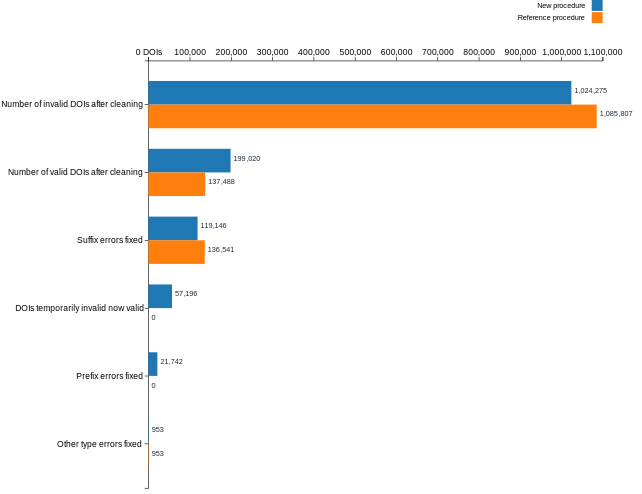

In [6]:
from IPython.display import SVG, display
display(SVG(url='https://raw.githubusercontent.com/open-sci/2020-2021-grasshoppers-code/main/docs/img/results_barchart.svg'))

The comparison to the reference study made by Xu et al (2019) shows that the methods used in this research were able to clean more DOIs overall. However, which could be seen as surprising, applying the methods from Xu et al, 17,395 more suffix errors could be cleaned, while the number of prefix errors in the given dataset according to them results to zero. This result can be explained taking a closer look at the regular expressions and the definition of prefix- and suffix-type errors used by Xu et al. In the study presented here, the regular expression for prefix errors was a bit broader, as it also included different strings before the two possible DOI Proxy Server URLs, while Xu et al. only matched DOIs beginning with exactly those URLs, which, in the given dataset by Peroni (2021), results to 0 matches. The higher number of cleaned suffix errors using the methods by Xu et al can be explained by the same reason. As the algorithm presented here checks a DOI name subsequently for prefix, then suffix and in the end other-type errors, the errors not catched as prefix errors in the first place, can still be cleaned as suffix errors in the next step. Presumably, the mentioned type of error was fixed as suffix error with the regular expression, which lead to the higher number.